The Transformer Neural Network (NN) architecture that has emerged in recent years leverages encoders to capture the information contained in a large amount of inputs using a much smaller representation. Another way of saying this is that the encoders construct a lower-dimensional representation of a large feature space that retains a high proportion of the information that was expressed in the high-dimensional space.

To provide some clarity on the previous statement, in this notebook, we will first explore the possibility of using dimensionality reduction (DR) techniques to solve a predictive modeling problem that is often used as an introduction to computer vision. Specifically, we will explore the utility of using dimensionality reduction techniques to correctly predict handwritten digits from the MNIST dataset. From https://en.wikipedia.org/wiki/MNIST_database:
> The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.
>
> The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. The original creators of the database keep a list of some of the methods tested on it. In their original paper, they use a support-vector machine to get an error rate of 0.8%

Although the dimensionality reduction exercise we will explore is not an encoder in the sense we see with NNs, the core concept of reducing dimension while retaining information is the same. The following code block imports the libraries we will use.

In [1]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pacmap
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.model_selection import train_test_split

The following code block reads both the feature data (`data`) and the labels (`target`).

In [2]:
data = pd.read_parquet('mnist_data.parquet')
target = pd.read_parquet('mnist_target.parquet')

The following code block shows that we have 70,000 examples in our data.

In [3]:
data.shape

(70000, 784)

As the previous cell shows, there are 784 columns in the feature data. Recall from the earlier description that the MNIST dataset includes images of size 28 pixels x 28 pixels. The total number of pixels is 784 (28 x 28), so each row represents a flattened vector of the pixels for a single image. The following code block defines a function to plot the image for a single row.

In [4]:
def plot_digit(index=0):

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.heatmap(
        data.iloc[index].values.reshape(28, 28),
        cmap='binary',
        cbar=False,
    )

    plt.show()

The following code block runs an interactive widget that allows you to view a sample of digits.

In [5]:
interact(plot_digit, index=range(100));

interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

The following code block creates training and testing datasets.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data, 
    target, 
    test_size=0.20, 
    random_state=42,
    stratify=target,
)

#### DR Technique 1: Principal Components Analysis (PCA)

We will first look at how Principal Components Analysis fares for dimensionality reduction task. The following code block imports the PCA class from `scikit-learn`, fits the model on the training set with 2 components, and then prints the explained variance, which is rather low.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)

sum(pca.explained_variance_ratio_)

0.1686680613353322

The following code block uses the fitted PCA to generate the reduced dimension embeddings for the training and testing datasets. 

In [8]:
pca_emb_train = pca.transform(X_train)
pca_emb_test = pca.transform(X_test)

Before we do any predictive modeling, let's visualize the PCA embeddings. This is done in the following code block, which first creates a `pandas` `DataFrame` with the embeddings and then generates a scatterplot that uses different colors for each label. The key thng to note is that the separation between classes is rather indistinct.

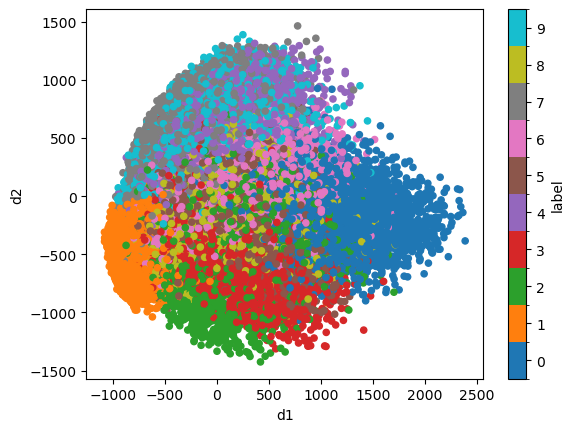

In [9]:
pca_emb_df = pd.DataFrame(
    pca_emb_train,
    columns=['d1', 'd2'],
)
pca_emb_df['label'] = y_train['class'].values

pca_emb_df.plot(
    kind='scatter',
    x='d1',
    y='d2',
    c='label',
    alpha=1.0,
    cmap='tab10',
);

The following code block runs an experiment where we use the labels to construct binary classification problems for each class. A random forest is then trained to predict the class based on the PCA embeddings. The baseline accuracy (accuracy we would get if we predicted none of the instances belonged to a class), training accuracy, and testing accuracy are printed for each of the classes in the data.

In [10]:
unique_classes = sorted(y_train['class'].unique().tolist())

for current_class in unique_classes:

    y_train_class = (y_train['class'] == current_class).astype(int)
    y_test_class = (y_test['class'] == current_class).astype(int)
    
    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        n_jobs=6,
    )
    
    clf.fit(pca_emb_train, y_train_class)
    train_accuracy = clf.score(pca_emb_train, y_train_class)
    test_accuracy = clf.score(pca_emb_test, y_test_class)
    baseline_accuracy = 1.0 - y_train_class.sum()/len(y_train_class)
    
    print(f'Class: {current_class}')
    print(f' - {baseline_accuracy = :.4f}')
    print(f' - {train_accuracy = :.4f}')
    print(f' - {test_accuracy = :.4f}')
    print('-'*40)

Class: 0
 - baseline_accuracy = 0.9014
 - train_accuracy = 0.9540
 - test_accuracy = 0.9478
----------------------------------------
Class: 1
 - baseline_accuracy = 0.8875
 - train_accuracy = 0.9841
 - test_accuracy = 0.9801
----------------------------------------
Class: 2
 - baseline_accuracy = 0.9001
 - train_accuracy = 0.9090
 - test_accuracy = 0.9060
----------------------------------------
Class: 3
 - baseline_accuracy = 0.8980
 - train_accuracy = 0.9193
 - test_accuracy = 0.9143
----------------------------------------
Class: 4
 - baseline_accuracy = 0.9025
 - train_accuracy = 0.9054
 - test_accuracy = 0.9035
----------------------------------------
Class: 5
 - baseline_accuracy = 0.9098
 - train_accuracy = 0.9100
 - test_accuracy = 0.9098
----------------------------------------
Class: 6
 - baseline_accuracy = 0.9018
 - train_accuracy = 0.9029
 - test_accuracy = 0.9016
----------------------------------------
Class: 7
 - baseline_accuracy = 0.8958
 - train_accuracy = 0.9176
 - 

The previous results show that PCA is able to make some substantial improvements for a small number of classes (e.g., 0 and 1), but in general, it does not consistenly yield significant improvements over the baseline. 

#### DR Technique 2: Pairwise Controlled Manifold Approximation (PaCMAP)

We will now look at PACMAP (see https://github.com/YingfanWang/PaCMAP). The following code block fits a *default* version of the method and uses it to create training and testing sets of embedded values. **Note the need to provide a `basis` argument when transforming the test dataset.

In [11]:
reducer = pacmap.PaCMAP(random_state=42)

pacmap_emb_train = reducer.fit_transform(X_train)
pacmap_emb_test = reducer.transform(X_test, basis=X_train)

/home/nkfreeman/miniconda3/envs/crisp_env/lib/python3.11/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


The following code block visualizes the `PACMAP` embeddings. As you can see, the embeddings separate the classes much more distinctly than we observed with PCA.

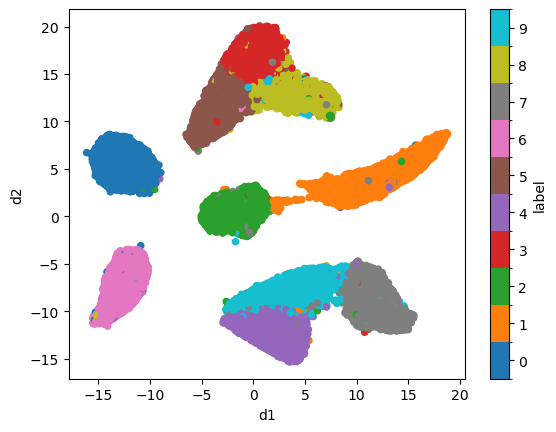

In [12]:
pacmap_emb_df = pd.DataFrame(
    pacmap_emb_train,
    columns=['d1', 'd2'],
)
pacmap_emb_df['label'] = y_train['class'].values

pacmap_emb_df.plot(
    kind='scatter',
    x='d1',
    y='d2',
    c='label',
    alpha=1.0,
    cmap='tab10',
);

The following code block runs an experiment where we use the labels to construct binary classification problems for each class. A random forest is then trained to predict the class based on the PACMAP embeddings. The baseline accuracy (accuracy we would get if we predicted none of the instances belonged to a class), training accuracy, and testing accuracy are printed for each of the classes in the data. In contrast to PCA, the lower-dimensional representations learned by the PACMAP method allow us to predict the correct class with around 99% accuracy, on average. Another important thing to note  is that we are doing all of this without a convolutional neural network.

In [13]:
unique_classes = sorted(y_train['class'].unique().tolist())

for current_class in unique_classes:

    y_train_class = (y_train['class'] == current_class).astype(int)
    y_test_class = (y_test['class'] == current_class).astype(int)
    
    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        n_jobs=6,
    )
    
    clf.fit(pacmap_emb_train, y_train_class)
    train_accuracy = clf.score(pacmap_emb_train, y_train_class)
    test_accuracy = clf.score(pacmap_emb_test, y_test_class)
    baseline_accuracy = 1.0 - y_train_class.sum()/len(y_train_class)
    
    print(f'Class: {current_class}')
    print(f' - {baseline_accuracy = :.4f}')
    print(f' - {train_accuracy = :.4f}')
    print(f' - {test_accuracy = :.4f}')
    print('-'*40)

Class: 0
 - baseline_accuracy = 0.9014
 - train_accuracy = 0.9986
 - test_accuracy = 0.9968
----------------------------------------
Class: 1
 - baseline_accuracy = 0.8875
 - train_accuracy = 0.9972
 - test_accuracy = 0.9953
----------------------------------------
Class: 2
 - baseline_accuracy = 0.9001
 - train_accuracy = 0.9959
 - test_accuracy = 0.9891
----------------------------------------
Class: 3
 - baseline_accuracy = 0.8980
 - train_accuracy = 0.9933
 - test_accuracy = 0.9869
----------------------------------------
Class: 4
 - baseline_accuracy = 0.9025
 - train_accuracy = 0.9963
 - test_accuracy = 0.9927
----------------------------------------
Class: 5
 - baseline_accuracy = 0.9098
 - train_accuracy = 0.9962
 - test_accuracy = 0.9908
----------------------------------------
Class: 6
 - baseline_accuracy = 0.9018
 - train_accuracy = 0.9980
 - test_accuracy = 0.9946
----------------------------------------
Class: 7
 - baseline_accuracy = 0.8958
 - train_accuracy = 0.9955
 - 

#### Transformers and Huggingface

Hopefully, the previous code blocks have demonstrated the power of dimensionality reduction. We will now look at how **Transformers** can be applied to reduce the dimensionality of text, which has led to the explosion of generative AI solutions that have emerged recently.

The following code block imports some additional libraries we will need for this demonstration.

In [14]:
from sentence_transformers import SentenceTransformer
import torch

The following code block loads the pre-trained `all-MiniLM-L6v2` sentence transformer model that is available via Huggingface (https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).

In [15]:
st_model = SentenceTransformer('all-MiniLM-L6-v2')

The following code block reads a dataset that contains the abstracts for scholarly publications on Covid-19. A list of abstracts is created and stored in an object named `abstracts`. The first abstract is printed.

In [16]:
abstract_data = pd.read_csv('covid_abstracts.csv')
abstracts = abstract_data['abstract'].tolist()

abstracts[0]

'This article summarizes the experiences of COVID-19 patients diagnosed and treated at Faulkton Area Medical Center  FAMC   a rural critical access facility in South Dakota  during three periods of COVID-19  Retrospective chart review was used to classify COVID-19 patients into three groups by time frame  1 Early March 2020  with the arrival of COVID-19 to South Dakota  until August 31  2020  2 September 1  2020  with the use of rapid result direct COVID-19 virus antigen testing  through November 24 2020  which took place during our COVID-19 surge   and 3 November 25  2020  the start of bamlanivimab infusions on high-risk patients with COVID-19  throughFebruary15  2021  the cutoff for this review  Faulk County had higher COVID-19 case rates and COVID-19 death rates than South Dakota in general  Final review of the data showed stable overall hospitalization rates at FAMC in each of these time periods  Data was broken down by age and not other demographics due to small patient population

In [17]:
%%time

embeddings = st_model.encode(abstracts[:100], device='cpu')

CPU times: user 14.4 s, sys: 3.88 s, total: 18.3 s
Wall time: 4.56 s


In [18]:
%%time

embeddings = st_model.encode(abstracts[:100], device='cuda')

CPU times: user 1.71 s, sys: 104 ms, total: 1.81 s
Wall time: 1.2 s


The following code block uses the sentence transformer model to generate embeddings for the abstracts.

In [19]:
%%time

embeddings = st_model.encode(abstracts, device='cuda')

CPU times: user 1min 51s, sys: 346 ms, total: 1min 51s
Wall time: 1min 38s


The following code block uses the embeddings to list the titles of the 5 most similar articles for 10 of the abstracts.

In [20]:
embeddings_df = pd.DataFrame(
    embeddings,
    index=abstract_data.index,
)

for target in abstract_data.index.tolist()[:10]:

    similarities = cosine_similarity(
        embeddings_df.loc[target].values.reshape(1, -1),
        embeddings_df.values,
    )
    
    similar_articles = pd.Series(
        similarities.flatten(),
        index=abstract_data.index,
    ).nlargest(5).to_dict()
    
    target_paper = abstract_data.loc[target, 'title']
    abstract = abstract_data.loc[target, 'abstract']
    print(f"Target: {target_paper}\n")
    print(f"Abstract: {abstract}")
    print('\n')
    for sid, similarity in similar_articles.items():
        print(f" - {abstract_data.loc[sid, 'title']} ({similarity: .3f})")
    print('*'*100 + '\n')

Target: Real-World Experience with COVID-19  Including Direct COVID-19 Antigen Testing and Monoclonal-Antibody Bamlanivimab in a Rural Critical Access Hospital in South Dakota

Abstract: This article summarizes the experiences of COVID-19 patients diagnosed and treated at Faulkton Area Medical Center  FAMC   a rural critical access facility in South Dakota  during three periods of COVID-19  Retrospective chart review was used to classify COVID-19 patients into three groups by time frame  1 Early March 2020  with the arrival of COVID-19 to South Dakota  until August 31  2020  2 September 1  2020  with the use of rapid result direct COVID-19 virus antigen testing  through November 24 2020  which took place during our COVID-19 surge   and 3 November 25  2020  the start of bamlanivimab infusions on high-risk patients with COVID-19  throughFebruary15  2021  the cutoff for this review  Faulk County had higher COVID-19 case rates and COVID-19 death rates than South Dakota in general  Final re

The results of the previous code block show that the learned embeddings are able to identify similar articles. We can also use the embeddings to identify clusters of similar articles by applying the PaCMAP dimensionality reduction technique we saw earlier when considering the handwritten digits. The following code block fits the PaCMAP reducer, generates the embeddings for the reduced dimension vectors, and generates a scatter plot of the articles in the lower dimensional space.

/home/nkfreeman/miniconda3/envs/crisp_env/lib/python3.11/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


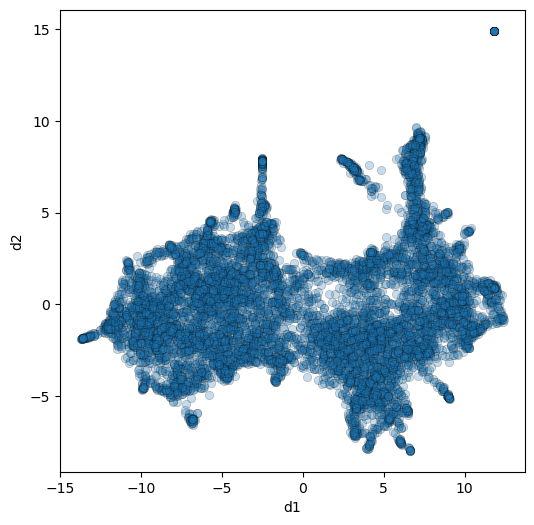

In [21]:
reducer = pacmap.PaCMAP(n_components=2, random_state=42)
pacmap_embeddings = reducer.fit_transform(embeddings_df.values)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_df = pd.DataFrame(
    pacmap_embeddings,
    index=abstract_data.index,
    columns=['d1', 'd2'],
)

sns.scatterplot(
    data=plot_df,
    x='d1',
    y='d2',
    alpha=0.25,
    edgecolor='k',
)

plt.show()

Let's look more closely at the abstracts associated with the cluster of arguments that is very seperated from the others.

In [22]:
clustered_papers = plot_df[plot_df['d2']> 12].index.tolist()
for paper in clustered_papers:
    print(f' - {abstract_data.loc[paper, "title"]}')

 - Discrimination and surveillance of infectious severe acute respiratory syndrome Coronavirus 2 in wastewater using cell culture and RT-qPCR
 - Comparison of high-frequency in-pipe SARS-CoV-2 wastewater-based surveillance to concurrent COVID-19 random clinical testing on a public U S  university campus
 - A nationwide indicator to smooth and normalize heterogeneous SARS-CoV-2 RNA data in wastewater
 - SARS-CoV-2 circulation in Croatian wastewaters and the absence of SARS-CoV-2 in bivalve molluscan shellfish
 - A sensitive and rapid wastewater test for SARS-COV-2 and its use for the early detection of a cluster of cases in a remote community
 - Polio Environmental Surveillance and Its Application to SARS-CoV-2 Detection
 - SARS-CoV-2 wastewater surveillance in Germany  Long-term RT-digital droplet PCR monitoring  suitability of primer probe combinations and biomarker stability
 - Surveillance of SARS-CoV-2 in Sewage Treatment Plants between January 2020 and July 2021 in Taiwan
 - Envir